> The notebook version of this post can be downloaded [here](https://github.com/jtrive84/jtrive84.github.io/blob/master/posts/practical-nlp-for-risk-modeling-part-2/practical-nlp-for-risk-modeling-part-2.ipynb).


In [Part I](https://www.jtrive.com/posts/practical-nlp-for-risk-modeling-part-1/practical-nlp-for-risk-modeling-part-1.html) of the *Practical NLP for Risk Modeling* series, we walked through how to use a pre-trained transformer model as a frozen feature extractor for classifying tornado severity based on NOAA event narratives. Each narrative was embedded into a 768-dimensional vector, then trained using a regularized Logistic Regression head. That baseline exhibited solid performance, and has a nice property: Once the text is embedded, everything downstream looks like a normal tabular modeling problem.

In Part II we remove the frozen constraint and fine-tune DistilBERT end-to-end on the tornado severity classification task. A small classification head is attached directly to the pretrained model, and the entire network is trained jointly on the task. During training, the model adjusts the classification layer as well as the internal language representations to better align with the target labels. The goal is to measure the performance gain over and above the frozen baseline by letting the language model adapt to NOAA narrative phrasing and severity cues.

We'll stick to `distilbert-base-uncased` to remain consistent with Part I. All code checks for CUDA. If a GPU is present it will accelerate training dramatically, but nothing here requires one.

Since the first installment of this series, the transformers library has been updated. To ensure the code provided here is reproducible into the future, it is strongly encouraged that a new virtual environment be created with the following dependencies:



```
# requirements.txt
numpy==1.26.4
pandas==2.2.1
scikit-learn==1.4.2
scipy==1.12.0
torch==2.4.1

# Hugging Face stack (Trainer-capable)
transformers==5.1.0
accelerate==1.3.0
datasets==2.18.0
evaluate==0.4.1

# Must match Transformers v5 requirements
tokenizers
huggingface-hub

# Utilities
tqdm==4.66.2
pyarrow==15.0.2
sentencepiece==0.2.0

# Additional
matplotlib==3.8.3
wordcloud==1.9.6
bs4 
requests 
contextily
geopandas
```

<br>

These can be installed directly from GitHub by executing the next cell:

In [1]:
!python -m pip install -r https://gist.githubusercontent.com/jtrive84/e313afbf2def24687e3c3247aa836fe9/raw/f2493005d291920dc1fcfd54274b9dfa42004ebe/requirements.txt --quiet


<br>

The code to download the NOAA Storm Events database is reproduced from the first post for convenience. We first check whether *noaa-events-2008-2025.parquet* exists in the current working directory. If not, the files are downloaded and saved locally. Subsequent executions of the next cell will read your local copy of the database:


In [2]:

import os
import pandas as pd
import requests
from bs4 import BeautifulSoup

base_url = "https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/"


def get_latest_details_file(year):
    """
    Return the filename of the latest details file for the given year.
    Sample filename: StormEvents_details-ftp_v1.0_d2022_c20250721.csv.gz
    """
    html = requests.get(base_url).text
    soup = BeautifulSoup(html, "html.parser")
    candidates = [
        a["href"]
        for a in soup.find_all("a", href=True)
        if f"StormEvents_details-ftp_v1.0_d{year}" in a["href"]
    ]

    return sorted(candidates)[-1]


# Check if dataset exists locally prior to hitting NOAA servers.
if not os.path.exists("noaa-events-2008-2025.parquet"):
    
    print("Fetching latest filenames from NOAA servers...")
    # Get latest filenames for years 2008-2025.
    latest_filenames = [get_latest_details_file(year) for year in range(2008, 2026)]

    # Load each file into a DataFrame and concatenate.
    dfall = pd.concat(
        [pd.read_csv(f"{base_url + fname}", compression="gzip") for fname in latest_filenames],
        ignore_index=True,
    )
else:
    print("Loading dataset locally...")
    dfall = pd.read_parquet("noaa-events-2008-2025.parquet")

print(f"Total records loaded: {dfall.shape[0]:,}")
dfall.head()



Loading dataset locally...
Total records loaded: 1,158,836


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200802,22,1300,200802,22,2200,14216,79884,NEW HAMPSHIRE,33,...,NaN,None,None,NaN,NaN,NaN,NaN,A noreaster moved up the coast southeast of Ca...,None,CSV
1,200804,1,352,200804,1,352,15549,88334,NEW HAMPSHIRE,33,...,NaN,None,None,NaN,NaN,NaN,NaN,Strong southwest flow behind a warm front allo...,An amateur radio operator recorded a wind gust...,CSV
2,200803,1,0,200803,1,1320,14773,83820,NEW HAMPSHIRE,33,...,NaN,None,None,NaN,NaN,NaN,NaN,Low pressure tracked from the Great Lakes acro...,None,CSV
3,200801,14,500,200801,14,1700,13559,75727,NEW HAMPSHIRE,33,...,NaN,None,None,NaN,NaN,NaN,NaN,Low pressure moved up the Atlantic coast and s...,None,CSV
4,200812,19,1353,200812,21,200,25148,146588,NEW HAMPSHIRE,33,...,NaN,None,None,NaN,NaN,NaN,NaN,An intensifying coastal low spread heavy snow ...,Six to eight inches of snow fell across easter...,CSV


 
Pre-processing is handled the same as in Part I:

- Retain events from 2008 to present.
- Keep only records with EVENT_TYPE = "Tornado". 
- Drop records having TOR_F_SCALE "EFU", "EF0", "EF1","F0", "F1".
- CLASS = 0 for EF2 events, CLASS = 1 for (EF3, EF4 and EF5) events.
- Create a DatasetDict, with training set including events from 2008-2022 and test set events from 2023-2025. 



In [3]:

import warnings

from datasets import Dataset, DatasetDict
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

np.set_printoptions(suppress=True, precision=5, linewidth=1000)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.precision", 5)
warnings.filterwarnings("ignore")


# Filter for tornadoes from 2008 onward with significant damage ratings.
df = (
    dfall[
        (dfall.YEAR >= 2008) & 
        (dfall.EVENT_TYPE == "Tornado") & 
        (~dfall.TOR_F_SCALE.isin(["EFU", "EF0", "EF1" ,"F0", "F1"]))
    ]
    .dropna(subset=["EVENT_NARRATIVE"])
    .drop_duplicates(subset=["EVENT_NARRATIVE"])
    .reset_index(drop=True)
)

# Strip whitespace from EVENT_NARRATIVE.
df["EVENT_NARRATIVE"] = df["EVENT_NARRATIVE"].str.replace(r"\s+", " ", regex=True).str.strip()

# Create target class based on TOR_F_SCALE.
df["CLASS"] = np.where(df.TOR_F_SCALE.isin(["EF2"]), 0, 1)

keep_columns = [
    "EVENT_ID",
    "EVENT_NARRATIVE",
    "TOR_F_SCALE",
    "BEGIN_LAT",
    "BEGIN_LON",
    "CLASS"
]

# Create train-test splits. 
dftrain = df[df["YEAR"] <= 2022][keep_columns].reset_index(drop=True)
dfvalid = df[df["YEAR"] >  2022][keep_columns].reset_index(drop=True)

# Create Dataset objects.
ds_train = Dataset.from_pandas(dftrain)
ds_valid = Dataset.from_pandas(dfvalid)
ds = DatasetDict({"train": ds_train, "valid": ds_valid})

print(f"Train size: {len(dftrain):,}")
print(f"Valid size: {len(dfvalid):,}\n")
print(f"Training sample:\n{ds_train[0]}")


c:\Users\jtriv\miniforge3\envs\bert\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train size: 2,620
Valid size: 641

Training sample:
{'EVENT_ID': 105611, 'EVENT_NARRATIVE': 'A tornado damaged numerous trees, including large trees uprooted, blew windows out of a home, destroyed a metal shed, blew two windows and part of a wall out of a metal building, damaged at least three grain bins, destroyed or damaged numerous outbuildings and small sheds, blew down or snapped off at least 15 power poles, bent a metal light pole, tipped one wagon and blew the top off another, blew down a barb wire fence and pushed fence posts almost to the ground, destroyed a hog barn, and flattened corn stubble, before crossing the county line into Lyon County. Contents inside several damaged or destroyed buildings and sheds were also damaged, especially on one farm where damaged buildings housed a farm and trucking business.', 'TOR_F_SCALE': 'EF2', 'BEGIN_LAT': 43.1421, 'BEGIN_LON': -96.3, 'CLASS': 0}



We can visualize the starting points for each training set tornado. CLASS=0 events are shown in blue, CLASS=1 in red. 

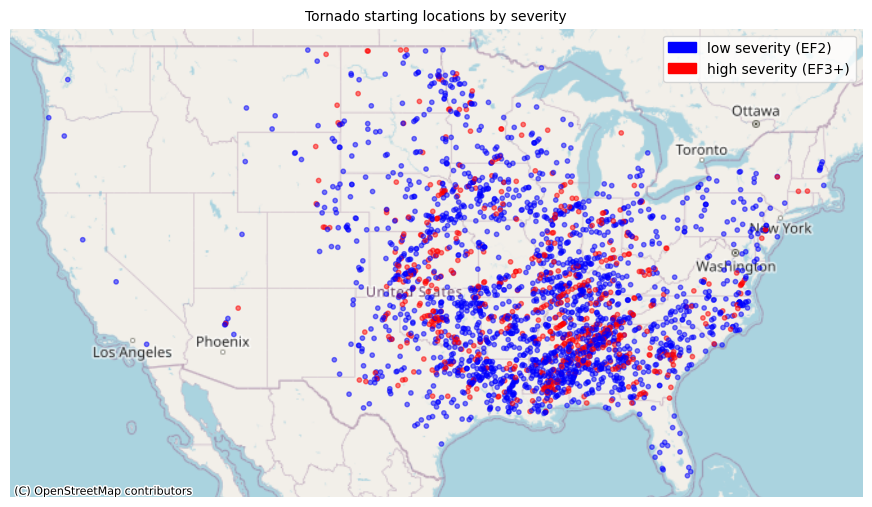

In [4]:

import geopandas as gpd
import contextily as cx


gdf = gpd.GeoDataFrame(
    {"CLASS":  dftrain["CLASS"]},
    geometry=gpd.points_from_xy(dftrain["BEGIN_LON"], dftrain["BEGIN_LAT"]),
    crs="EPSG:4326",
).to_crs("EPSG:3857")

ax = gdf.plot(
    figsize=(11, 8.5),
    markersize=10,
    alpha=0.5,
    color=gdf["CLASS"].map({0: "blue", 1: "red"})
)
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.collections[0].set_color(gdf["CLASS"].map({0: "blue", 1: "red"}).tolist())
ax.set_title("Tornado starting locations by severity", fontsize=10)
colors = gdf["CLASS"].map({0: "blue", 1: "red"}).tolist()
ax.collections[0].set_color(colors)
ax.set_axis_off()

# Legend.
handles = [
    mpl.patches.Patch(color="blue", label="low severity (EF2)"),
    mpl.patches.Patch(color="red", label="high severity (EF3+)"),
]
ax.legend(handles=handles, title=None, loc="upper right", frameon=True)

plt.show()


<br>

### **Fine-Tuned Transformer Classifier (DistilBERT end-to-end)**

Our objective is to train DistilBERT end-to-end by attaching a classification head and updating all weights. This is the simplest all-transformer setup, where text is provided as input and class probabilities are produced as output. 



In [5]:

from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
    average_precision_score,

)

model_name = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)

print(f"\nDevice: {device}")



Device: cpu


<br>

As before we begin with tokenization, this time using the Hugging Face dataset mapping API. This keeps tokenization tied to the dataset object and avoids manual tensor management until training time. `ds_tokenized.set_format("torch")` ensures all features are automatically converted to `torch.Tensor` objects.

When fine-tuning a transformer, each training batch contains sequences of different lengths. While we already specified a maximum sequence length during tokenization, we do not want to pad every example in the dataset to that maximum ahead of time. Doing so would waste memory and slow training, especially on CPU.

`DataCollatorWithPadding` solves this by performing dynamic padding at batch time. For each batch, it looks at the longest sequence in that batch and pads all other sequences just enough to match it. The tokenizer is passed into the collator so it knows which padding token to use and how to construct the corresponding attention masks.

In [6]:

def tokenize_batch(batch):
    return tokenizer(
        batch["EVENT_NARRATIVE"],
        truncation=True,
        max_length=512
    )

ds_tokenized = ds.map(tokenize_batch, batched=True)
ds_tokenized = ds_tokenized.remove_columns(["EVENT_NARRATIVE", "TOR_F_SCALE", "EVENT_ID", "BEGIN_LAT", "BEGIN_LON"])
ds_tokenized = ds_tokenized.rename_column("CLASS", "labels")
ds_tokenized.set_format("torch")

collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map: 100%|██████████| 641/641 [00:00<00:00, 5777.82 examples/s]


<br>

DistilBERT with 2 classes produces logits of shape (N, 2). We convert logits to probabilities using softmax, then take P(class=1). `compute_metrics` is passed into the `Trainer` object initialized in a few cells, which provides us with validation metrics at each epoch. 

In [7]:

def softmax(x):
    x = x - x.max(axis=1, keepdims=True)
    exp_x = np.exp(x)
    return exp_x / exp_x.sum(axis=1, keepdims=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = softmax(logits)[:, 1]
    preds = (probs >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(labels, preds),
        "roc_auc": roc_auc_score(labels, preds),
        "precision": average_precision_score(labels, probs),
    }
    

<br>

In the next cell, when `AutoModelForSequenceClassification.from_pretrained` is called, three things happen at once:

1. The pretrained DistilBERT encoder weights are loaded from Hugging Face. This is the same transformer we used in Part I as a frozen feature extractor. 

2. A fully-connected neural network head is added on top of the encoder. For sequence classification, this is a linear layer that takes the model's internal representation of the input sequence and maps it to `num_labels` outputs. For our dataset, the head outputs two logits (CLASS=0 and CLASS=1). 

3. The model is configured end-to-end so that both the encoder and the classification head are trainable. During fine-tuning, gradients flow from the classification loss back through the head and into DistilBERT's layers. This is what allows the model to adapt to NOAA-specific language and severity cues.


In [8]:

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)


Loading weights: 100%|██████████| 100/100 [00:00<00:00, 964.04it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]    
DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


`TrainingArguments` is the configuration object that tells the Hugging Face Trainer how to run training. More on available options can be found [here](https://huggingface.co/docs/transformers/en/main_classes/trainer). 

In [9]:

args = TrainingArguments(
    output_dir="distilbert-noaa",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="roc_auc",
    greater_is_better=True
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["valid"],
    data_collator=collator,
    compute_metrics=compute_metrics
)


<br>

All that's left to do is train and evaluate. I kept `num_train_epochs` low assuming CPU training. Feel free to increase this value if GPU acceleration is available. On my machine, training via CPU for 5 epochs took ~1.5 hours: 

In [ ]:

trainer.train()
eval_out = trainer.evaluate()

print("Fine-tuned DistilBERT validation metrics:")
print(eval_out)


Epoch,Training Loss,Validation Loss,Accuracy,Roc Auc,Precision
1,0.502981,0.484903,0.801872,0.596458,0.499649
2,0.183584,0.259172,0.939158,0.912315,0.852742
3,0.258704,0.231112,0.948518,0.911132,0.917165
4,0.108387,0.235922,0.945398,0.923599,0.923016
5,0.084391,0.243583,0.951638,0.917981,0.925314


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


Fine-tuned DistilBERT validation metrics:
{'eval_loss': 0.23589347302913666, 'eval_accuracy': 0.9453978159126365, 'eval_roc_auc': 0.92359900373599, 'eval_precision': 0.923015586437536, 'eval_runtime': 98.0304, 'eval_samples_per_second': 6.539, 'eval_steps_per_second': 0.418, 'epoch': 5.0}



<br>

Generate the classification report:

In [11]:

pred_out = trainer.predict(ds_tokenized["valid"])
logits = pred_out.predictions
p1 = softmax(logits)[:, 1] 
y_valid = pred_out.label_ids

# Assume 0.50 threshold for time being.
y_pred = (p1 >= 0.5).astype(int)

print(classification_report(y_valid, y_pred, digits=5))


              precision    recall  f1-score   support

           0    0.96559   0.96364   0.96461       495
           1    0.87755   0.88356   0.88055       146

    accuracy                        0.94540       641
   macro avg    0.92157   0.92360   0.92258       641
weighted avg    0.94554   0.94540   0.94546       641




We are now in a position to compare results from Part I. Recall the classification summary from our frozen embeddings model:

```
              precision    recall  f1-score   support

           0    0.89447   0.71919   0.79731       495
           1    0.42798   0.71233   0.53470       146

    accuracy                        0.71763       641
   macro avg    0.66123   0.71576   0.66601       641
weighted avg    0.78822   0.71763   0.73750       641

```

<br>

The big takeaway is that fine-tuning delivers a step-change improvement. Accuracy, precision and recall improved across the board, but what really stands out is the increase in CLASS=1 precision. In Part 1, CLASS=1 precision of ~0.43 meant that more than half of the events flagged as severe were actually EF2. It might catch severe events, but it would generate a lot of false positives. After fine-tuning, CLASS=1 precision jumped to ~0.84. Now, when the model says "this looks like an EF3+ event", it's usually correct. We're no longer trading false positives for recall: the model is genuinely better at recognizing severe events from event narratives. From an insurance perspective, that's the difference between an exploratory model and something that could potentially support triage or prioritization.


### **Conclusion**

Fine-tuning DistilBERT end-to-end on tornado narratives led to a dramatic improvement in classification performance compared to using frozen embeddings. Precision and recall for EF3+ events both increased substantially, which indicates that the model has learned severity-specific language patterns that embeddings alone weren't able to fully capture. However, the improvement fine-tuning provided came at the cost of 15x longer training time, greater computational overhead, and a more complex modeling pipeline. Whether that tradeoff is worthwhile depends on how much narrative detail is truly necessary for the task in question.

In Part III, we explore that question directly by evaluating whether compressed versions of the original text can achieve comparable performance, and how much information can be removed before predictive power begins to degrade.

